In [2]:
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu
import copy
from rasterio.transform import from_origin
from skimage import feature, morphology, measure
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString
import geopandas as gpd
from rasterio.features import shapes
from skimage.transform import rescale 
from shapely.geometry import shape

In [ ]:
# file path to the composite image
satellite_path = r"composite.tif"  # Replace with your planet image composite
shapefile_path = "boundary_clip_new.shp"  # Replace here with study area shapefile

In [4]:
composite_img = rio.open(satellite_path)
boundary = gpd.read_file(shapefile_path)

In [5]:
# Read the green and NIR bands from the composite image
green = composite_img.read(2).astype(float) 
nir = composite_img.read(4).astype(float)

C:\Users\Sreevisal\AppData\Local\Temp\ipykernel_8524\4148141478.py:3: RuntimeWarning: invalid value encountered in divide
  ndwi=np.where((green + nir)==0.,0, (green - nir)/(green + nir))


-0.5557676401348858
0.9655756207674944


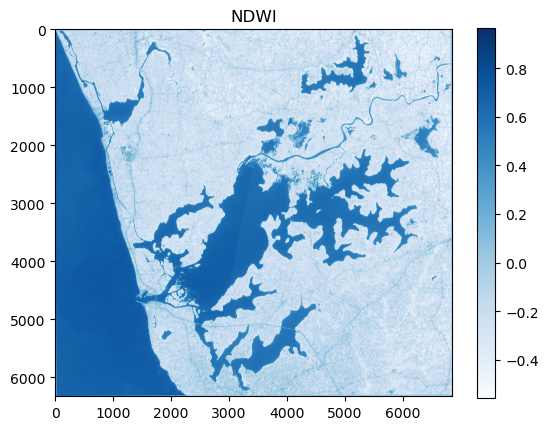

False


In [7]:
# Calculating NDWI
                     # Condition for No Data value: if sum of green and NIR is 0, set NDWI to 0
ndwi=np.where((green + nir)==0.,0, (green - nir)/(green + nir))

print(ndwi.min())
print(ndwi.max())
plt.imshow(ndwi,cmap = 'Blues')
plt.colorbar()  # Add a colorbar for reference
plt.title('NDWI')
plt.show()

has_nan = np.isnan(ndwi).any()
print(has_nan)

**Thresholding**

In [8]:
threshold = threshold_otsu(ndwi)
binary = ndwi > threshold

print(threshold)

0.2019326167598543


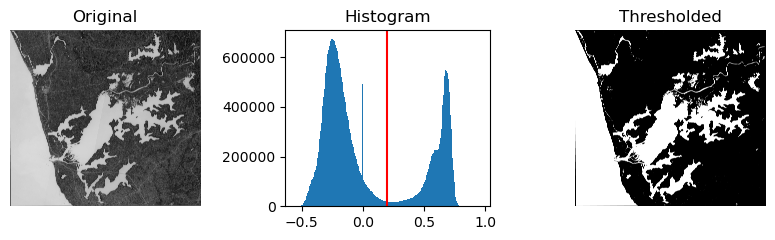

In [9]:
plt.figure(figsize=(8, 2.5))

plt.subplot(1, 3, 1)
plt.imshow(ndwi, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.hist(ndwi.ravel(), bins=256)
plt.title('Histogram')
plt.axvline(threshold, color='r')

plt.subplot(1, 3, 3)
plt.imshow(binary, cmap=plt.cm.gray)
plt.title('Thresholded')
plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
binary_new = copy.copy(ndwi)
# set all pixels with MNDWI < 0 to 0, keeping only values > 0 (surface water bodies)
# insert Otsu threshold value
binary_new[ndwi < threshold] = 0
binary_new[ndwi >= threshold] = 1 
print(binary_new)
print(binary_new.max())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
1.0


Removing Small Waterbodies

In [9]:
from skimage.morphology import remove_small_objects

# Define pixel size and the area threshold (in pixels)
pixel_size = 3  # pixel size in meters
area_threshold = 1000000 / (pixel_size ** 2)  # area threshold in pixels

# Remove small waterbodies
filtered_water = remove_small_objects(binary, min_size=area_threshold)



**Edge Detection**

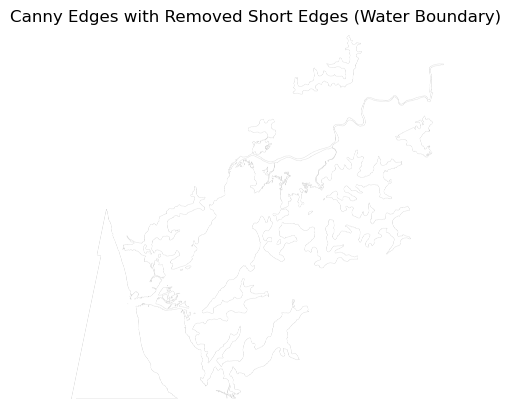

In [10]:
from skimage.filters import threshold_otsu, gaussian
# Smooth the binary image using Gaussian filter
smoothed_water = gaussian(filtered_water, sigma=2)  # Adjust sigma as needed
filtered_water = smoothed_water > 0.5

# Perform Canny edge detection on the binary mask
edges = feature.canny(filtered_water, sigma=1)  # Adjust sigma as needed

# # Apply dilation to increase the thickness of the edges
# edges = morphology.dilation(edges, morphology.disk(1.5))

# Display the Canny edges image after removing short edges and increasing thickness
plt.imshow(edges, cmap='binary')  # 'binary' colormap goes from black to white
plt.title('Canny Edges with Removed Short Edges (Water Boundary)')
plt.axis('off')
plt.show()

Clipping the unwanted portions 

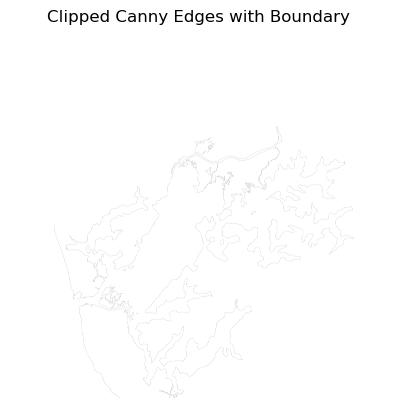

In [13]:
# Create a mask from the boundary shapefile
mask_geom = boundary.unary_union

# Convert the mask to a raster format with the same shape and transform as the composite image
mask_raster = rio.features.rasterize(
    [(mask_geom, 1)],
    out_shape=filtered_water.shape,
    transform=composite_img.transform,
    fill=0,
    dtype=np.uint8
)

# Clip the edges using the mask
clipped_edges = np.where(mask_raster, edges, 0)

# Perform morphological closing to smooth the edges
closed_edges = morphology.binary_closing(clipped_edges, morphology.square(3))

# Display the clipped edges
plt.imshow(clipped_edges, cmap='binary')
plt.title('Clipped Canny Edges with Boundary')
plt.axis('off')
plt.show()

Saving as Shapefile

In [ ]:
# Extract shapes from the edges array
mask = closed_edges > 0
shapes_gen = shapes(closed_edges.astype(np.int32), mask=mask, transform=composite_img.transform)

# Create a list to hold shapely LineString geometries
line_geometries = []
for shape_pair in shapes_gen:
    geom, value = shape_pair
    if value > 0:
        geom_shape = shape(geom)
        print(f"Extracted shape: {geom_shape}")  
        if isinstance(geom_shape, (Polygon, MultiPolygon)):
            for poly in geom_shape.geoms if isinstance(geom_shape, MultiPolygon) else [geom_shape]:
                line = LineString(poly.exterior.coords)
                line_geometries.append(line)

# Ensure there are valid geometries
if line_geometries:
    # Merge all LineStrings into a single MultiLineString
    merged_lines = MultiLineString(line_geometries)
    
    # Create a GeoDataFrame with LineString geometries
    gdf = gpd.GeoDataFrame(crs=composite_img.crs, geometry=[merged_lines])

    # Save the GeoDataFrame as a Shapefile
    gdf.to_file("2024.shp")

    print(gdf)
else:
    print("No valid geometries found.")

Extracted shape: POLYGON ((679431 996948, 679431 996936, 679434 996936, 679434 996945, 679437 996945, 679437 996948, 679431 996948))
Extracted shape: POLYGON ((679428 996936, 679428 996927, 679425 996927, 679425 996918, 679428 996918, 679428 996924, 679431 996924, 679431 996936, 679428 996936))
Extracted shape: POLYGON ((679500 996921, 679500 996915, 679497 996915, 679497 996906, 679500 996906, 679500 996912, 679503 996912, 679503 996918, 679506 996918, 679506 996921, 679500 996921))
Extracted shape: POLYGON ((679494 996906, 679494 996900, 679497 996900, 679497 996906, 679494 996906))
Extracted shape: POLYGON ((679422 996918, 679422 996912, 679419 996912, 679419 996888, 679422 996888, 679422 996909, 679425 996909, 679425 996918, 679422 996918))
Extracted shape: POLYGON ((679491 996900, 679491 996897, 679488 996897, 679488 996894, 679485 996894, 679485 996891, 679482 996891, 679482 996885, 679485 996885, 679485 996888, 679488 996888, 679488 996891, 679491 996891, 679491 996894, 679494 9